In [1]:
# pip install transformers datasets

     ---------------------------------------- 0.0/44.1 kB ? eta -:--:--
     -------------------------- ----------- 30.7/44.1 kB 640.0 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/44.1 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 44.1/44.1 kB 360.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.6 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 764.4 kB/s eta 0:00:00
     ---------------------------------------- 0.0/69.9 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/69.9 kB ? eta -:--:--
     ---------------- --------------------- 30.7/69.9 kB 640.0 kB/s eta 0:00:01
     --------------------------------- ---- 61.4/69.9 kB 544.7 kB/s eta 0:00:01


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
!python -m torch.utils.collect_env

PyTorch version: 2.5.1+cu124
Is debug build: False
CUDA used to build PyTorch: 12.4
ROCM used to build PyTorch: N/A

OS: Microsoft Windows 11 Home Single Language
GCC version: (Rev2, Built by MSYS2 project) 10.3.0

Clang version: Could not collect
CMake version: Could not collect
Libc version: N/A

Python version: 3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)] (64-bit runtime)
Python platform: Windows-10-10.0.22631-SP0
Is CUDA available: True
CUDA runtime version: 12.0.140

CUDA_MODULE_LOADING set to: LAZY
GPU models and configuration: GPU 0: NVIDIA GeForce GTX 1650
Nvidia driver version: 566.14
cuDNN version: Could not collect
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

CPU:
Architecture=9


CurrentClockSpeed=3000


DeviceID=CPU0


Family=107


L2CacheSize=3072


L2CacheSpeed=


Manufacturer=AuthenticAMD


MaxClockSpeed=3000


Name=AMD Ryzen 5 4600H with Radeon Graphics         


ProcessorType=3


Revision=24577



<frozen runpy>:128: RuntimeWarning: 'torch.utils.collect_env' found in sys.modules after import of package 'torch.utils', but prior to execution of 'torch.utils.collect_env'; this may result in unpredictable behaviour


In [1]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

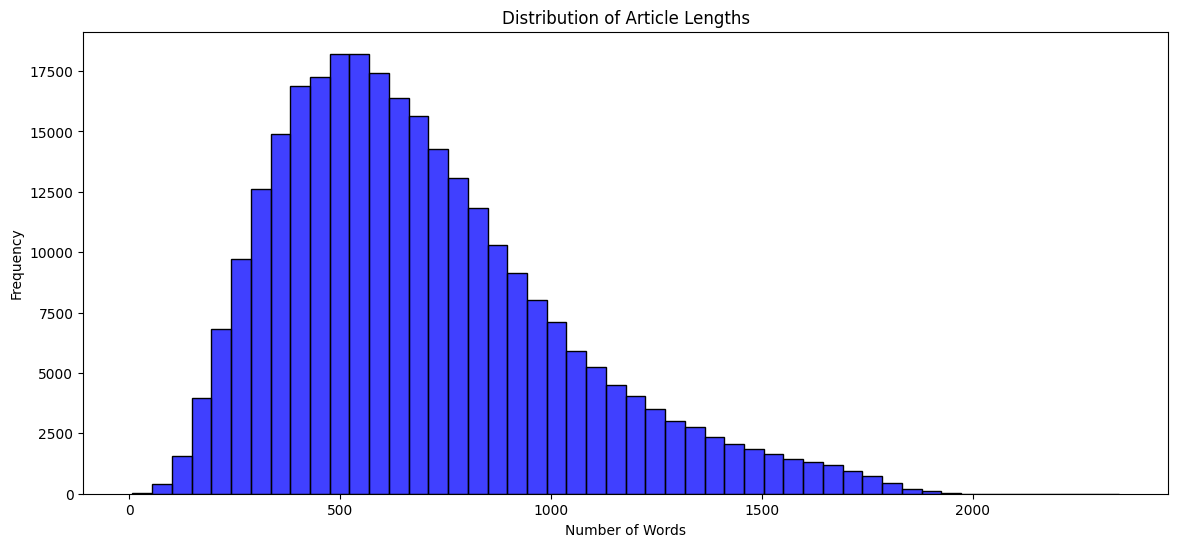

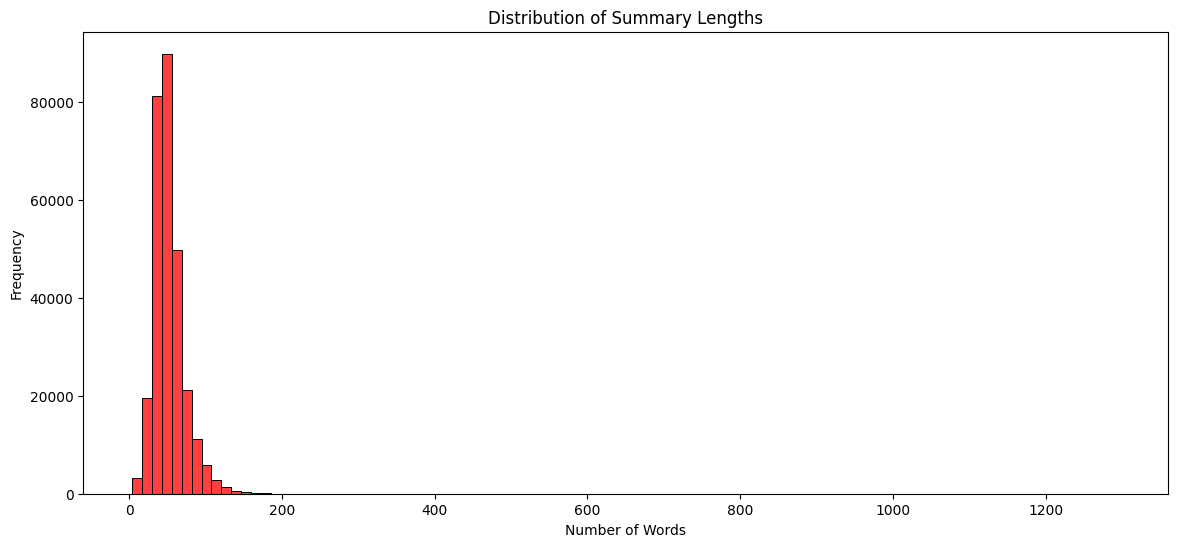

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# Compute lengths
article_lengths = [len(article.split()) for article in dataset['train']['article']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['highlights']]

# Plotting Article Lengths
plt.figure(figsize=(14, 6))
sns.histplot(article_lengths, bins=50, color='blue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Plotting Summary Lengths
plt.figure(figsize=(14, 6))
sns.histplot(summary_lengths, bins=100, color='red')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

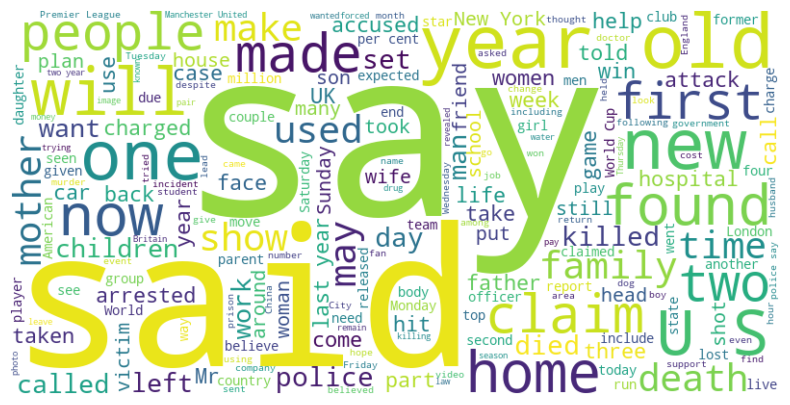

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all summaries
text = " ".join(summary for summary in dataset['train']['highlights'])

# Optionally, you can clean the text (remove stopwords, punctuation, etc.)
# For example:
# text = clean_text_function(text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Disable axis
plt.show()

In [2]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained('lucadiliello/bart-small')
model = BartForConditionalGeneration.from_pretrained('lucadiliello/bart-small')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


In [3]:
# Check the number of articles and highlights pairs in the dataset
train_size = len(dataset['train'])
validation_size = len(dataset['validation'])
test_size = len(dataset['test'])

print(train_size, validation_size, test_size)

287113 13368 11490


In [14]:
# Resize the model's token embeddings to match the tokenizer's vocabulary size
model.resize_token_embeddings(len(tokenizer))

BartScaledWordEmbedding(50265, 512, padding_idx=1)

In [15]:
def preprocess_function(examples):
    # Tokenize articles and highlights
    inputs = tokenizer(examples['article'], padding='max_length', truncation=True, max_length=1024)
    labels = tokenizer(examples['highlights'], padding='max_length', truncation=True, max_length=150)

    # Ensure that labels are padded to the same length as inputs
    inputs['labels'] = labels['input_ids']

    # Replace padding tokens in the labels with -100 so they are ignored in the loss calculation
    inputs['labels'] = [
        [label if label != tokenizer.pad_token_id else -100 for label in label_list]
        for label_list in inputs['labels']
    ]

    return inputs


# Apply the preprocessing function to the dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [16]:
import torch
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)
device

device(type='cuda', index=0)

In [17]:
# import torch
# torch.cuda.empty_cache()

In [18]:
# import os

# # Set the environment variable before importing PyTorch
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [22]:
from transformers import Trainer, TrainingArguments


# Define training arguments
training_args = TrainingArguments(  
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=2,  
    per_device_eval_batch_size=2,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',
    report_to="none",
    remove_unused_columns=False,
)

# Initialize Trainer with subset datasets
trainer = Trainer(
    model=model.to(device),           
    args=training_args,            
    train_dataset=tokenized_datasets['train'], 
    eval_dataset=tokenized_datasets['validation'],  
)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [23]:
tokenized_datasets["train"].shape

(287113, 6)

In [24]:
tokenized_datasets["validation"].shape

(13368, 6)

In [25]:
tokenized_datasets["validation"][0]

{'article': '(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don\'t know, but the fact that so many people can have a life extension, that\'s pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I\'m just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard\'s gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacifi

In [20]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [8]:
# Start training
trainer.train()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [9]:
print(tokenizer.decode(tokenized_datasets['train'][0]['input_ids']))
print(tokenizer.decode(tokenized_datasets['train'][0]['labels']))

<s>LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of 

In [31]:
print(model.config.vocab_size)

50264


In [ ]:
print(dataset)

NameError: name 'dataset' is not defined